In [2]:
import scanpy as sc
from scprint2 import scPRINT2
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download
import lamindb as ln

from scprint.tasks import Embedder
from scprint.tasks.cell_emb import display_confusion_matrix
import pandas as pd

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from anndata import AnnData
from scdataloader.utils import translate
import bionty as bt
from scprint.tasks.cell_emb import compute_classification

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from scdataloader import SimpleAnnDataset, Collator, DataModule
from torch.utils.data import DataLoader

import lamindb as ln

%load_ext autoreload
%autoreload 2

import torch
import scipy.sparse

torch.set_float32_matmul_precision("medium")

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [1]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
LOC = "../"
model_checkpoint_file = LOC + "models/18hebyht-final-small.ckpt"
# w937u4o1.ckpt'
# da6ao55o.ckpt # 649
# 1lzuxvg0.ckpt # 677

In [ ]:
model = scPrint.load_from_checkpoint(
    model_checkpoint_file, precpt_gene_emb=None, attention="normal"
)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [3]:
LOC = "/pasteur/appa/scratch/jkalfon/data/"  # "./"

da = sc.read(LOC + "task_3_embed.h5ad")
da

AnnData object with n_obs × n_vars = 27200 × 57066
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'cell_type', 'batch', 'barcode', 'celltype', 'percent.mt', 'integrated_snn_res.1', 'NewCelltype', 'n_genes', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'batches', 'leiden', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'CL:0000001', 'CL:0000003', 'CL:0000019', 'CL:0000023', 'CL:0000024', 'CL:0000032', 'CL:0000047', 'CL:0000049', 'CL:0000050', 'CL:0000051', 'CL:0000062', 'CL:0000091', 'CL:0000092', 'CL:0000097', 'CL:0000114', 'CL:0000119', 'CL:0000121', 'CL:0000122', 'CL:0000128', 'CL:0000131', 'CL:0000132', 'CL:0000133', 'CL:0000138', 'CL

In [15]:
da.obs = da.obs.loc[:, da.obs.columns[:34]]

In [9]:
(da.X > 0).sum(1).mean(), (da.X > 0).sum(1).max(), (da.X > 0).sum(1).min()

(1633.3526102941175, 8354, 202)

In [10]:
((da.X > 0).sum(1) > 2800).sum()

2934

In [5]:
map_to_val = {n: i for i, n in enumerate(set(da.obs["batch"].unique()))}
da.obs["batch"] = da.obs["batch"].map(map_to_val)

In [6]:
# Prepare data for fine-tuning (using the cat/tiger dataset from above)
# Split data into train/val
n_train = int(0.8 * len(da))
train_idx = np.random.choice(len(da), n_train, replace=False)
val_idx = np.setdiff1d(np.arange(len(da)), train_idx)

train_data = da[train_idx].copy()
val_data = da[val_idx].copy()

print(f"Training data: {train_data.shape}")
print(f"Validation data: {val_data.shape}")

mencoders = {}
for k, v in model.label_decoders.items():
    mencoders[k] = {va: ke for ke, va in v.items()}
# this needs to remain its original name as it is expect like that by collator, otherwise need to send org_to_id as params
mencoders.pop("organism_ontology_term_id")

# Create datasets
train_dataset = SimpleAnnDataset(
    train_data,
    obs_to_output=["cell_type_ontology_term_id", "batch", "organism_ontology_term_id"],
    get_knn_cells=model.expr_emb_style == "metacell",
    encoder=mencoders,
)

val_dataset = SimpleAnnDataset(
    val_data,
    obs_to_output=["cell_type_ontology_term_id", "batch", "organism_ontology_term_id"],
    get_knn_cells=model.expr_emb_style == "metacell",
    encoder=mencoders,
)

# Create collator
collator = Collator(
    organisms=model.organisms,
    valid_genes=model.genes,
    class_names=["cell_type_ontology_term_id", "batch"],
    how="random expr",  # or "all expr" for full expression
    max_len=2200,
    add_zero_genes=0,
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    collate_fn=collator,
    batch_size=32,  # Adjust based on GPU memory
    num_workers=4,
    shuffle=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    collate_fn=collator,
    batch_size=32,
    num_workers=4,
    shuffle=True,
    pin_memory=True,
)

Training data: (21760, 57066)
Validation data: (5440, 57066)


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


In [13]:
d_model_org = 8
d_model_cell = 256
batch_cls = torch.nn.Sequential(
    torch.nn.Linear(d_model_org, d_model_org * 8),
    torch.nn.ReLU(),
    torch.nn.Linear(d_model_org * 8, len(set(da.obs["batch"].unique()))),
)
batch_cls = batch_cls.to(model.device)

batch_emb = torch.nn.Embedding(len(set(da.obs["batch"].unique())), d_model_cell).to(
    model.device
)

In [14]:
for val in model.parameters():
    val.requires_grad = False
    # setting all to TRUE

for val in model.cell_transformer.parameters():
    val.requires_grad = True
for val in model.transformer.blocks[7].parameters():
    val.requires_grad = True
for i in model.transformer.blocks:
    i.cross_attn.requires_grad = True
for val in model.compressor.parameters():
    val.requires_grad = True
for val in model.cls_decoders["cell_type_ontology_term_id"].parameters():
    val.requires_grad = True

for val in batch_emb.parameters():
    val.requires_grad = True

In [9]:
def mmd_loss(X, Y):
    """
    Compute Maximum Mean Discrepancy (MMD) loss between two 2D embedding matrices.

    Args:
        X: Tensor of shape (n1, emb_dim) - first set of embeddings
        Y: Tensor of shape (n2, emb_dim) - second set of embeddings

    Returns:
        MMD loss value (negative to encourage dissimilarity)
    """

    def rbf_kernel(x, y, sigma):
        """Compute RBF kernel between two sets of vectors"""
        distance = torch.cdist(x, y, p=2) ** 2
        return torch.exp(-distance / (2 * sigma**2))

    def energy_kernel(x, y):
        """Compute Energy kernel between two sets of vectors"""
        distance = torch.cdist(x, y, p=2)
        return -distance

    # Use multiple kernel bandwidths for better performance
    sigmas = [0]  # [0.1, 1.0, 10.0]
    mmd_loss = 0.0

    for sigma in sigmas:
        # K(X, X) - kernel matrix within first group (n1 x n1)
        # k_xx = rbf_kernel(X, X, sigma)
        k_xx = energy_kernel(X, X)
        # K(Y, Y) - kernel matrix within second group (n2 x n2)
        # k_yy = rbf_kernel(Y, Y, sigma)
        k_yy = energy_kernel(Y, Y)
        # K(X, Y) - kernel matrix between groups (n1 x n2)
        # k_xy = rbf_kernel(X, Y, sigma)
        k_xy = energy_kernel(X, Y)

        # Unbiased MMD estimation
        n1 = X.shape[0]
        n2 = Y.shape[0]

        # Remove diagonal elements for unbiased estimation of K(X,X) and K(Y,Y)
        # For K(X,X): exclude diagonal
        if n1 > 1:
            mask_xx = 1 - torch.eye(n1, device=X.device)
            k_xx_term = (k_xx * mask_xx).sum() / (n1 * (n1 - 1))
        else:
            k_xx_term = 0.0

        # For K(Y,Y): exclude diagonal
        if n2 > 1:
            mask_yy = 1 - torch.eye(n2, device=Y.device)
            k_yy_term = (k_yy * mask_yy).sum() / (n2 * (n2 - 1))
        else:
            k_yy_term = 0.0

        # For K(X,Y): use all elements (no diagonal to exclude)
        k_xy_term = k_xy.mean()

        # MMD^2 = E[K(X,X)] + E[K(Y,Y)] - 2*E[K(X,Y)]
        mmd_squared = k_xx_term + k_yy_term - 2 * k_xy_term
        mmd_loss += mmd_squared

    # Return negative MMD to encourage dissimilarity (higher MMD = more different)
    return mmd_loss / len(sigmas)

In [15]:
def batch_corr_pass(batch):
    gene_pos = batch["genes"].to(model.device)
    expression = batch["x"].to(model.device)
    depth = batch["depth"].to(model.device)
    class_elem = batch["class"].long().to(model.device)
    total_loss = 0

    # Forward pass with automatic mixed precisio^n
    with torch.cuda.amp.autocast():
        # Forward pass
        output = model.forward(
            gene_pos,
            expression,
            req_depth=depth,
            depth_mult=expression.sum(1),
            do_class=True,
            metacell_token=torch.zeros_like(depth),
        )
        ## adaptor on ct_emb
        # ctpos = model.classes.index("cell_type_ontology_term_id") + 1
        # emb = output["output_cell_embs"][:, ctpos, :]
        #
        # output["output_cell_embs"][:, ctpos, :] = adaptor_layer(
        #    torch.cat([emb, class_elem[:, 1].unsqueeze(1).float()], dim=1)
        # )

        batch_pos = model.classes.index("organism_ontology_term_id") + 1
        output["output_cell_embs"][:, batch_pos, :] = batch_emb(class_elem[:, 1])

        ## generate expr loss
        output_gen = model._generate(
            cell_embs=output["output_cell_embs"],
            gene_pos=gene_pos,
            depth_mult=expression.sum(1),
            req_depth=depth,
        )
        if "zero_logits" in output_gen:
            loss_expr = loss.zinb(
                theta=output_gen["disp"],
                pi=output_gen["zero_logits"],
                mu=output_gen["mean"],
                target=expression,
            )
            if model.zinb_and_mse:
                loss_expr += (
                    loss.mse(
                        input=torch.log(output_gen["mean"] + 1)
                        * (1 - torch.sigmoid(output_gen["zero_logits"])),
                        target=torch.log(expression + 1),
                    )
                    / 10  # scale to make it more similar to the zinb
                )
        else:
            loss_expr = loss.mse(
                input=torch.log(output_gen["mean"] + 1),
                target=torch.log(expression + 1),
            )
        # Add expression loss to total
        total_loss += loss_expr

        # ct clss
        cls_output = output.get("cls_output_cell_type_ontology_term_id")
        # ct_output = output["output_cell_embs"][:, ctpos, :]
        # cls_output = model.cls_decoders["cell_type_ontology_term_id"](ct_output)
        cls_loss = loss.hierarchical_classification(
            pred=cls_output,
            cl=class_elem[:, 0],
            labels_hierarchy=model.mat_labels_hierarchy.get(
                "cell_type_ontology_term_id"
            ).to("cuda"),
        )

        # organ class
        # org_emb = output["compressed_cell_embs"][
        #    model.classes.index("organism_ontology_term_id") + 1
        # ]
        # cls_loss += F.cross_entropy(
        #    input=batch_cls(org_emb),
        #    target=class_elem[:, 1],
        # )
        total_loss += cls_loss

        pos = model.classes.index("cell_type_ontology_term_id") + 1
        # Apply gradient reversal to the input embedding
        selected_emb = (
            output["compressed_cell_embs"][pos]
            if model.compressor is not None
            else output["input_cell_embs"][:, pos, :]
        )
        X, Y = selected_emb[class_elem[:, 1] == 1], selected_emb[class_elem[:, 1] == 0]

        mmd = mmd_loss(X, Y)
        if torch.isnan(mmd):
            print("mmd nan")
        mmd = mmd.item() if not torch.isnan(mmd) else 0

        # Add adversarial loss to total loss
        total_loss += mmd * 3
        total_loss += output["vae_kl_loss"] * 0.5
    return total_loss, cls_loss, mmd, loss_expr

In [16]:
# Alternative: Manual Training Loop (for more control)
# If you prefer to have more control over the training process
from tqdm import tqdm
import torch.nn.functional as F
from scprint.model import loss

num_epochs = 8
lr = 0.0002
## PREPARING THE OPTIM
all_params = (
    list(model.parameters())
    # + list(batch_cls.parameters())
    + list(batch_emb.parameters())
)

# Setup optimizer
optimizer = torch.optim.AdamW(
    all_params, lr=lr, weight_decay=0.01, betas=(0.9, 0.999), eps=1e-8
)

# Setup scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.2, patience=1
)

# Setup automatic mixed precision
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

_ = model.train()

for k, i in model.mat_labels_hierarchy.items():
    model.mat_labels_hierarchy[k] = i.to(model.device)

/local/scratch/tmp/ipykernel_3087635/71163999.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


In [ ]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Training phase
    train_loss = 0.0
    train_steps = 0
    avg_adv = 0
    avg_expr = 0
    avg_cls = 0
    avg_mmd = 0

    # pbar = tqdm(train_loader, desc="Training")
    # for batch_idx, batch in enumerate(train_loader):
    #    optimizer.zero_grad()
    #    total_loss, cls_loss, mmd, loss_expr = batch_corr_pass(batch)
    #    # Backward pass
    #    scaler.scale(total_loss).backward()
    #    scaler.unscale_(optimizer)
    #    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    #    scaler.step(optimizer)
    #    scaler.update()
    #
    #    train_loss += total_loss.item()
    #    train_steps += 1
    #    avg_cls += cls_loss.item()
    #    avg_expr += loss_expr.item()
    #    avg_mmd += mmd
    # Update progress bar
    # if batch_idx % 35 == 0:
    # print(
    #    f"avg_loss {train_loss / train_steps:.4f}, avg_cls {avg_cls / train_steps:.4f}, avg_expr {avg_expr / train_steps:.4f}, avg_adv {avg_mmd/ train_steps:.4f}"
    # )
    # pbar.set_postfix(
    #    {
    #        "loss": f"{total_loss.item():.4f}",
    #        "avg_loss": f"{train_loss / train_steps:.4f}",
    #        "cls_loss": f"{cls_loss.item():.4f}",
    #        "mmd_loss": f"{mmd:.4f}",
    #        "expr_loss": f"{loss_expr.item():.4f}",
    #    }
    # )

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_steps = 0
    val_loss_expr = 0.0
    val_mmd = 0.0
    val_cls = 0.0
    val_loss_to_prt = 0.0

    with torch.no_grad():
        for batch in val_loader:  # tqdm(val_loader, desc="Validation"):
            loss_val, cls_loss, mmd, loss_expr = batch_corr_pass(batch)
            val_loss_to_prt += loss_val.item()
            val_loss += loss_val.item()
            val_steps += 1
            val_loss_expr += loss_expr.item()
            val_mmd += mmd
            val_cls += cls_loss.item()
    try:
        avg_val_loss = val_loss_to_prt / val_steps
        avg_train_loss = train_loss / train_steps
    except ZeroDivisionError:
        print("Error: Division by zero occurred while calculating average losses.")
        avg_train_loss = 0
    print(
        "cls_loss: {:.4f}, mmd_loss: {:.4f}, expr_loss: {:.4f}".format(
            val_cls / val_steps, val_mmd / val_steps, val_loss_expr / val_steps
        )
    )
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Store LR before scheduler step for comparison
    lr_before = optimizer.param_groups[0]["lr"]

    # Update learning rate
    scheduler.step(avg_val_loss)

    # Check if LR was reduced
    lr_after = optimizer.param_groups[0]["lr"]
    if lr_after < lr_before:
        print(
            f"🔻 Learning rate reduced from {lr_before:.2e} to {lr_after:.2e} (factor: {lr_after / lr_before:.3f})"
        )
    else:
        print(f"✅ Learning rate unchanged: {lr_after:.2e}")

    # Early stopping check (simple implementation)
    if epoch > 3 and val_loss / val_steps > 1.3 * avg_train_loss:
        print("Early stopping due to overfitting")
    break

print("Manual fine-tuning completed!")


Epoch 1/8
Current learning rate: 2.00e-04


/local/scratch/tmp/ipykernel_3087635/1819470300.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Error: Division by zero occurred while calculating average losses.
cls_loss: 0.0626, mmd_loss: 0.0255, expr_loss: 1.0383
Train Loss: 0.0000, Val Loss: 1.2187
✅ Learning rate unchanged: 2.00e-04
Manual fine-tuning completed!


In [29]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Training phase
    train_loss = 0.0
    train_steps = 0
    avg_adv = 0
    avg_expr = 0
    avg_cls = 0
    avg_mmd = 0

    # pbar = tqdm(train_loader, desc="Training")
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        total_loss, cls_loss, mmd, loss_expr = batch_corr_pass(batch)
        # Backward pass
        scaler.scale(total_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += total_loss.item()
        train_steps += 1
        avg_cls += cls_loss.item()
        avg_expr += loss_expr.item()
        avg_mmd += mmd
        # Update progress bar
        # if batch_idx % 35 == 0:
        # print(
        #    f"avg_loss {train_loss / train_steps:.4f}, avg_cls {avg_cls / train_steps:.4f}, avg_expr {avg_expr / train_steps:.4f}, avg_adv {avg_mmd/ train_steps:.4f}"
        # )
        # pbar.set_postfix(
        #    {
        #        "loss": f"{total_loss.item():.4f}",
        #        "avg_loss": f"{train_loss / train_steps:.4f}",
        #        "cls_loss": f"{cls_loss.item():.4f}",
        #        "mmd_loss": f"{mmd:.4f}",
        #        "expr_loss": f"{loss_expr.item():.4f}",
        #    }
        # )

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_steps = 0
    val_loss_expr = 0.0
    val_mmd = 0.0
    val_cls = 0.0
    val_loss_to_prt = 0.0

    with torch.no_grad():
        for batch in val_loader:  # tqdm(val_loader, desc="Validation"):
            loss_val, cls_loss, mmd, loss_expr = batch_corr_pass(batch)
            val_loss_to_prt += loss_val.item()
            val_loss += loss_val.item()
            val_steps += 1
            val_loss_expr += loss_expr.item()
            val_mmd += mmd
            val_cls += cls_loss.item()
    try:
        avg_val_loss = val_loss_to_prt / val_steps
        avg_train_loss = train_loss / train_steps
    except ZeroDivisionError:
        print("Error: Division by zero occurred while calculating average losses.")
        avg_train_loss = 0
    print(
        "cls_loss: {:.4f}, mmd_loss: {:.4f}, expr_loss: {:.4f}".format(
            val_cls / val_steps, val_mmd / val_steps, val_loss_expr / val_steps
        )
    )
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Store LR before scheduler step for comparison
    lr_before = optimizer.param_groups[0]["lr"]

    # Update learning rate
    scheduler.step(avg_val_loss)

    # Check if LR was reduced
    lr_after = optimizer.param_groups[0]["lr"]
    if lr_after < lr_before:
        print(
            f"🔻 Learning rate reduced from {lr_before:.2e} to {lr_after:.2e} (factor: {lr_after / lr_before:.3f})"
        )
    else:
        print(f"✅ Learning rate unchanged: {lr_after:.2e}")

    # Early stopping check (simple implementation)
    if epoch > 3 and val_loss / val_steps > 1.3 * avg_train_loss:
        print("Early stopping due to overfitting")
        break

print("Manual fine-tuning completed!")


Epoch 1/8
Current learning rate: 2.00e-04


/local/scratch/tmp/ipykernel_658467/1789452885.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


cls_loss: 0.5419, mmd_loss: 0.0432, expr_loss: 1.1199
Train Loss: 1.6328, Val Loss: 1.8512
✅ Learning rate unchanged: 2.00e-04

Epoch 2/8
Current learning rate: 2.00e-04
cls_loss: 0.0889, mmd_loss: 0.0250, expr_loss: 1.1117
Train Loss: 1.3386, Val Loss: 1.3123
✅ Learning rate unchanged: 2.00e-04

Epoch 3/8
Current learning rate: 2.00e-04
cls_loss: 0.0285, mmd_loss: 0.0229, expr_loss: 1.1244
Train Loss: 1.2708, Val Loss: 1.2478
✅ Learning rate unchanged: 2.00e-04

Epoch 4/8
Current learning rate: 2.00e-04
cls_loss: 0.2302, mmd_loss: 0.0225, expr_loss: 1.1003
Train Loss: 1.2226, Val Loss: 1.4181
✅ Learning rate unchanged: 2.00e-04

Epoch 5/8
Current learning rate: 2.00e-04
cls_loss: 0.0252, mmd_loss: 0.0187, expr_loss: 1.0592
Train Loss: 1.1953, Val Loss: 1.1569
✅ Learning rate unchanged: 2.00e-04

Epoch 6/8
Current learning rate: 2.00e-04
cls_loss: 0.0887, mmd_loss: 0.0149, expr_loss: 1.0484
Train Loss: 1.1718, Val Loss: 1.1969
✅ Learning rate unchanged: 2.00e-04

Epoch 7/8
Current lear

In [18]:
import lightning as L

checkpoint = {
    "epoch": epoch,
    "global_step": (1 + epoch) * batch_idx,
    "pytorch-lightning_version": L.__version__,
    "state_dict": model.state_dict(),
    "optimizer_states": [optimizer.state_dict()],
    "lr_schedulers": [scheduler.state_dict()],
    "hparams_name": None,
    "loops": None,
    "callbacks": None,
    "hyper_parameters": model.hparams,
}
torch.save(checkpoint, "fit_4.ckpt")

In [20]:
np.save("validation.npy", val_idx)

In [ ]:
# model.load_state_dict(torch.load("fit_2.ckpt")["state_dict"])

In [18]:
model = scPrint.load_from_checkpoint(
    "fit_4.ckpt", precpt_gene_emb=None, attention="normal"
)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [19]:
embed = Embedder(
    how="random expr",
    max_len=2800,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
)

In [20]:
da

AnnData object with n_obs × n_vars = 27200 × 57066
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'cell_type', 'batch', 'barcode', 'celltype', 'percent.mt', 'integrated_snn_res.1', 'NewCelltype', 'n_genes', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'batches', 'leiden', 'assay_ontology_term_id', 'cell_type_ontology_term_id'
    var: 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism', 'ensembl_gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'batch_colors', 'cell_type_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'

In [10]:
model.keep_all_labels_pred

True

In [21]:
n_adata, metrics = embed(model, da.copy())

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 425/425 [01:24<00:00,  5.01it/s]


logging the anndata
AnnData object with n_obs × n_vars = 27200 × 0
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'conv_pred_organism_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
t

In [24]:
n_adata.write_h5ad("fine_tuned_emb_task3.h5ad")

In [ ]:
n_adata = sc.read_h5ad("fine_tuned_emb_task3.h5ad")

In [23]:
compute_classification(
    n_adata,
    ["cell_type_ontology_term_id"],
    label_decoders=model.label_decoders,
    labels_hierarchy=model.labels_hierarchy,
)

{'cell_type_ontology_term_id': {'accuracy': 0.9405805038335159,
  'macro': 0.8035904056923585,
  'micro': 0.9405805038335159,
  'weighted': 0.9146044900507373}}

In [28]:
compute_classification(
    n_adata[val_idx],
    ["cell_type_ontology_term_id"],
    label_decoders=model.label_decoders,
    labels_hierarchy=model.labels_hierarchy,
)

{'cell_type_ontology_term_id': {'accuracy': 0.9277886497064579,
  'macro': 0.7873349813479226,
  'micro': 0.9277886497064579,
  'weighted': 0.8969559451240677}}

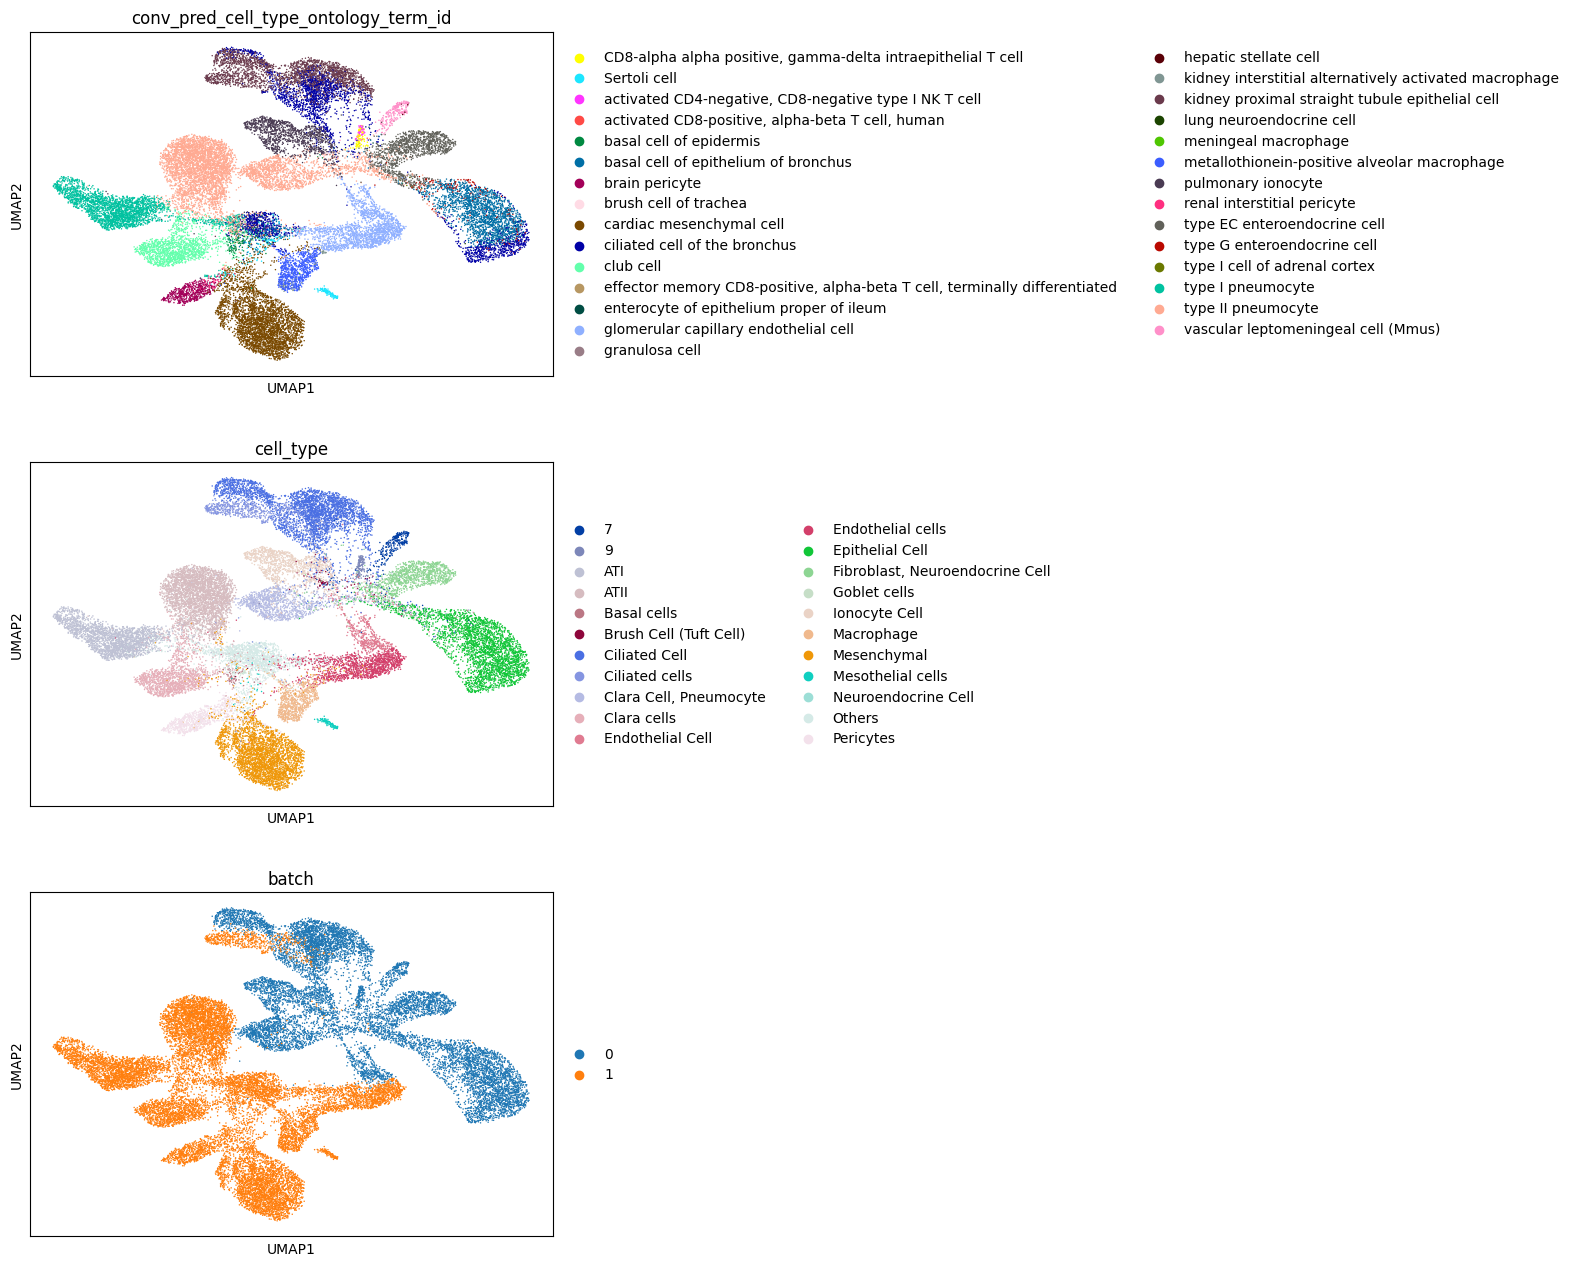

In [26]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb_cell_type_ontology_term_id")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

In [41]:
compute_classification(
    n_adata,
    ["cell_type_ontology_term_id"],
    label_decoders=model.label_decoders,
    labels_hierarchy=model.labels_hierarchy,
)

{'cell_type_ontology_term_id': {'accuracy': 0.9573227976842434,
  'macro': 0.8104771969842688,
  'micro': 0.9573227976842434,
  'weighted': 0.9386306624001126}}

In [27]:
n_adata.obs["simple_cell_type"] = n_adata.obs[
    "conv_pred_cell_type_ontology_term_id"
].replace(
    {
        n: n if i > 100 else "other"
        for n, i in n_adata.obs["conv_pred_cell_type_ontology_term_id"]
        .value_counts()
        .items()
    }
)

In [13]:
n_adata.obs["simple_cell_type"].value_counts()

simple_cell_type
type II pneumocyte                                              5167
glomerular capillary endothelial cell                           4913
kidney proximal straight tubule epithelial cell                 3761
cardiac mesenchymal cell                                        3289
type I pneumocyte                                               2714
club cell                                                       1487
type EC enteroendocrine cell                                    1464
pulmonary ionocyte                                              1060
brain pericyte                                                   790
other                                                            594
kidney interstitial alternatively activated macrophage           502
mature microglial cell                                           412
lung neuroendocrine cell                                         395
ciliated cell of the bronchus                                    221
Sertoli cell     

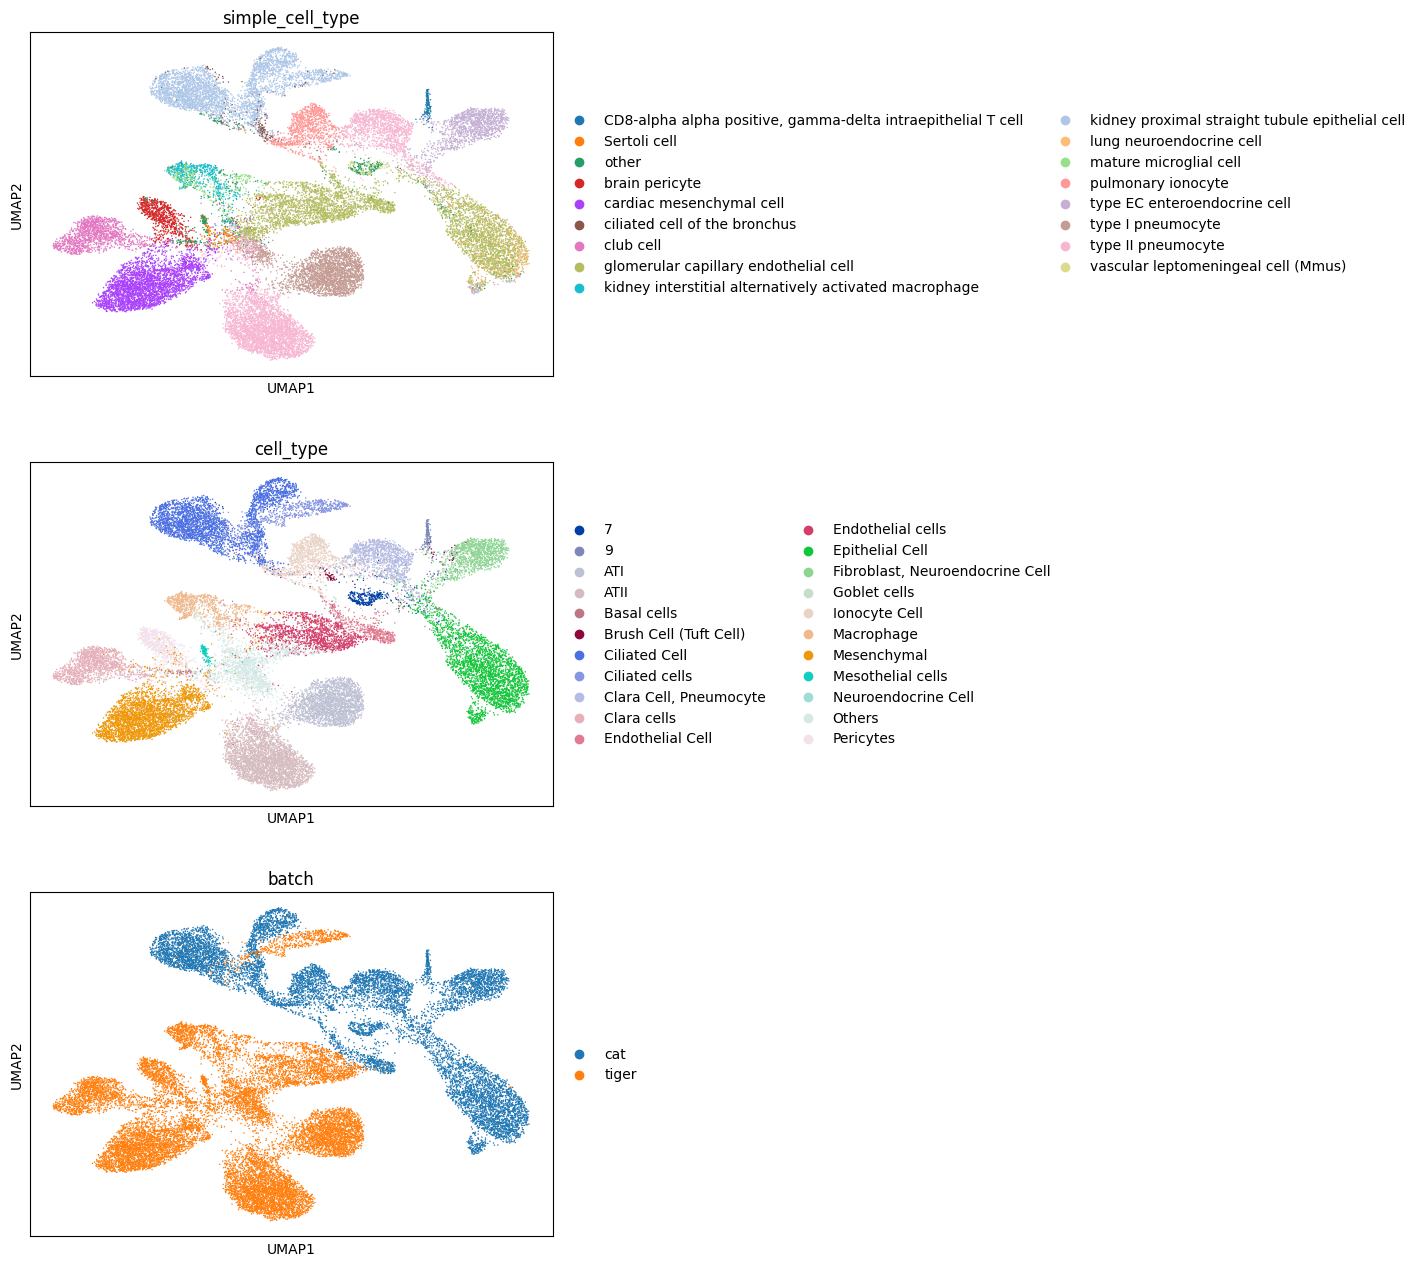

In [14]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb_cell_type_ontology_term_id")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["simple_cell_type", "cell_type", "batch"],
    ncols=1,
)

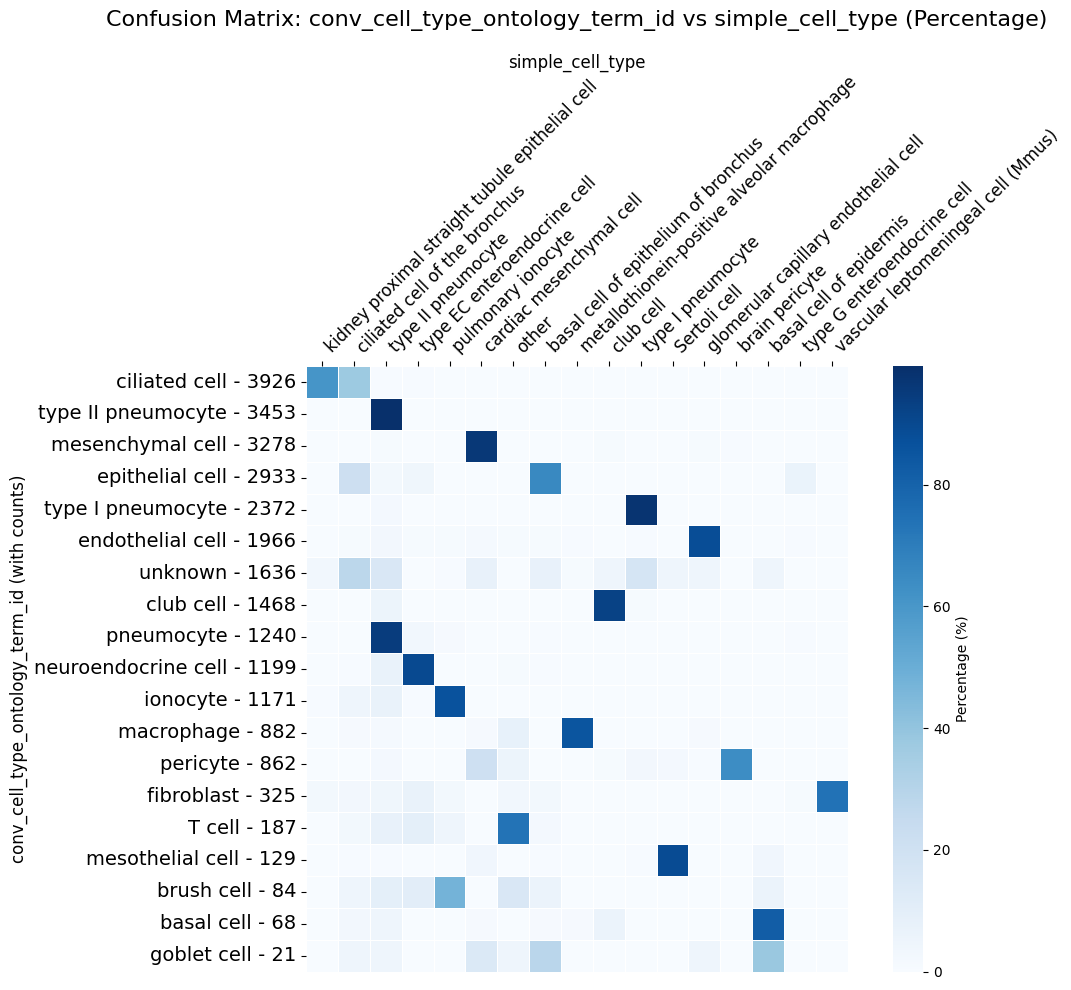

In [28]:
n_adata.obs["conv_pred_cell_type_ontology_term_id"] = translate(
    n_adata.obs["pred_cell_type_ontology_term_id"], "cell_type_ontology_term_id"
)
n_adata.obs["conv_cell_type_ontology_term_id"] = translate(
    n_adata.obs["cell_type_ontology_term_id"], "cell_type_ontology_term_id"
)
display_confusion_matrix(
    n_adata,
    "simple_cell_type",
    "conv_cell_type_ontology_term_id",
)

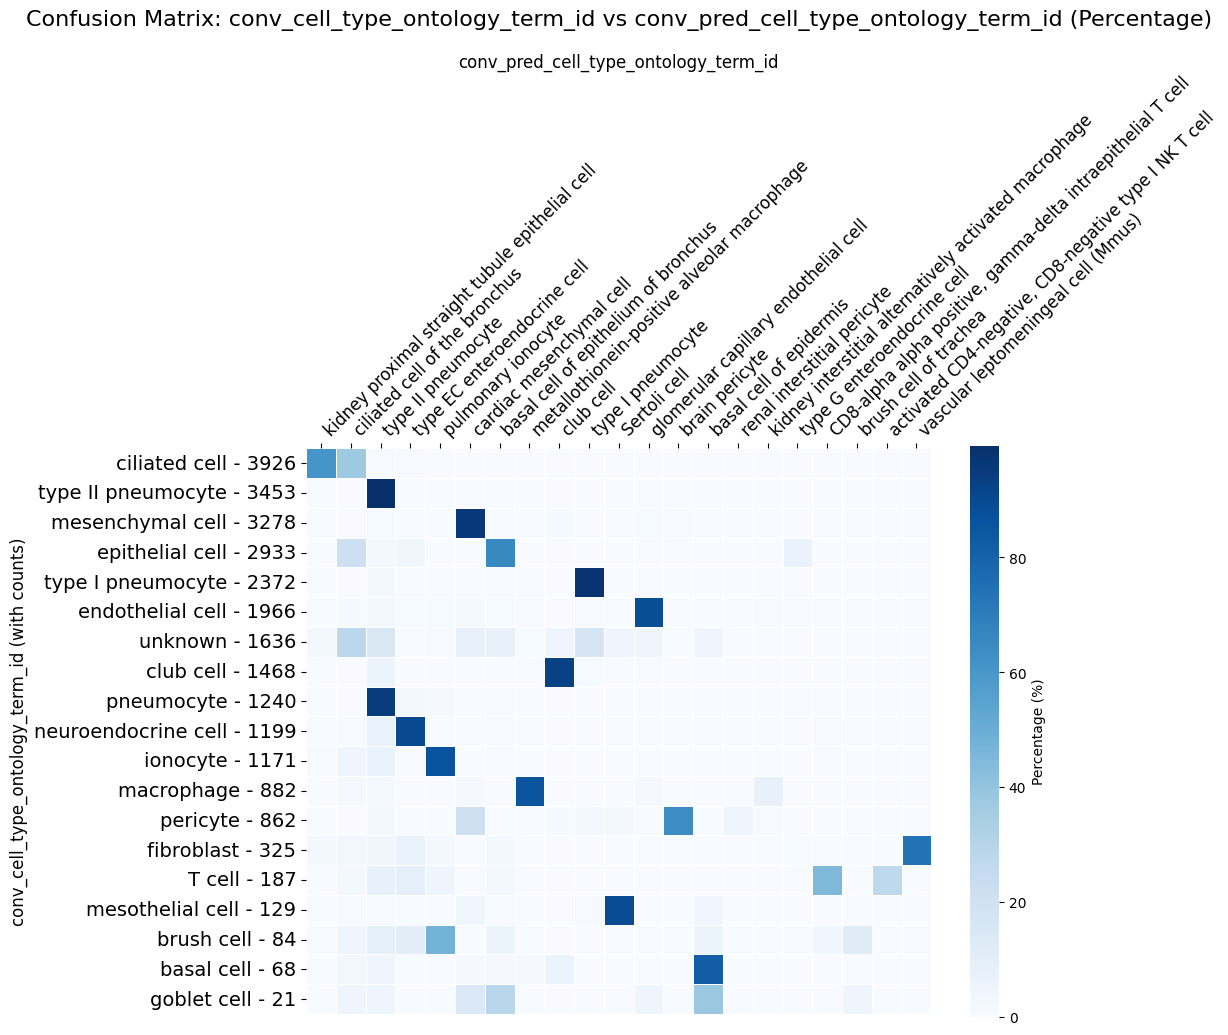

In [29]:
display_confusion_matrix(
    n_adata,
    "conv_pred_cell_type_ontology_term_id",
    "conv_cell_type_ontology_term_id",
)

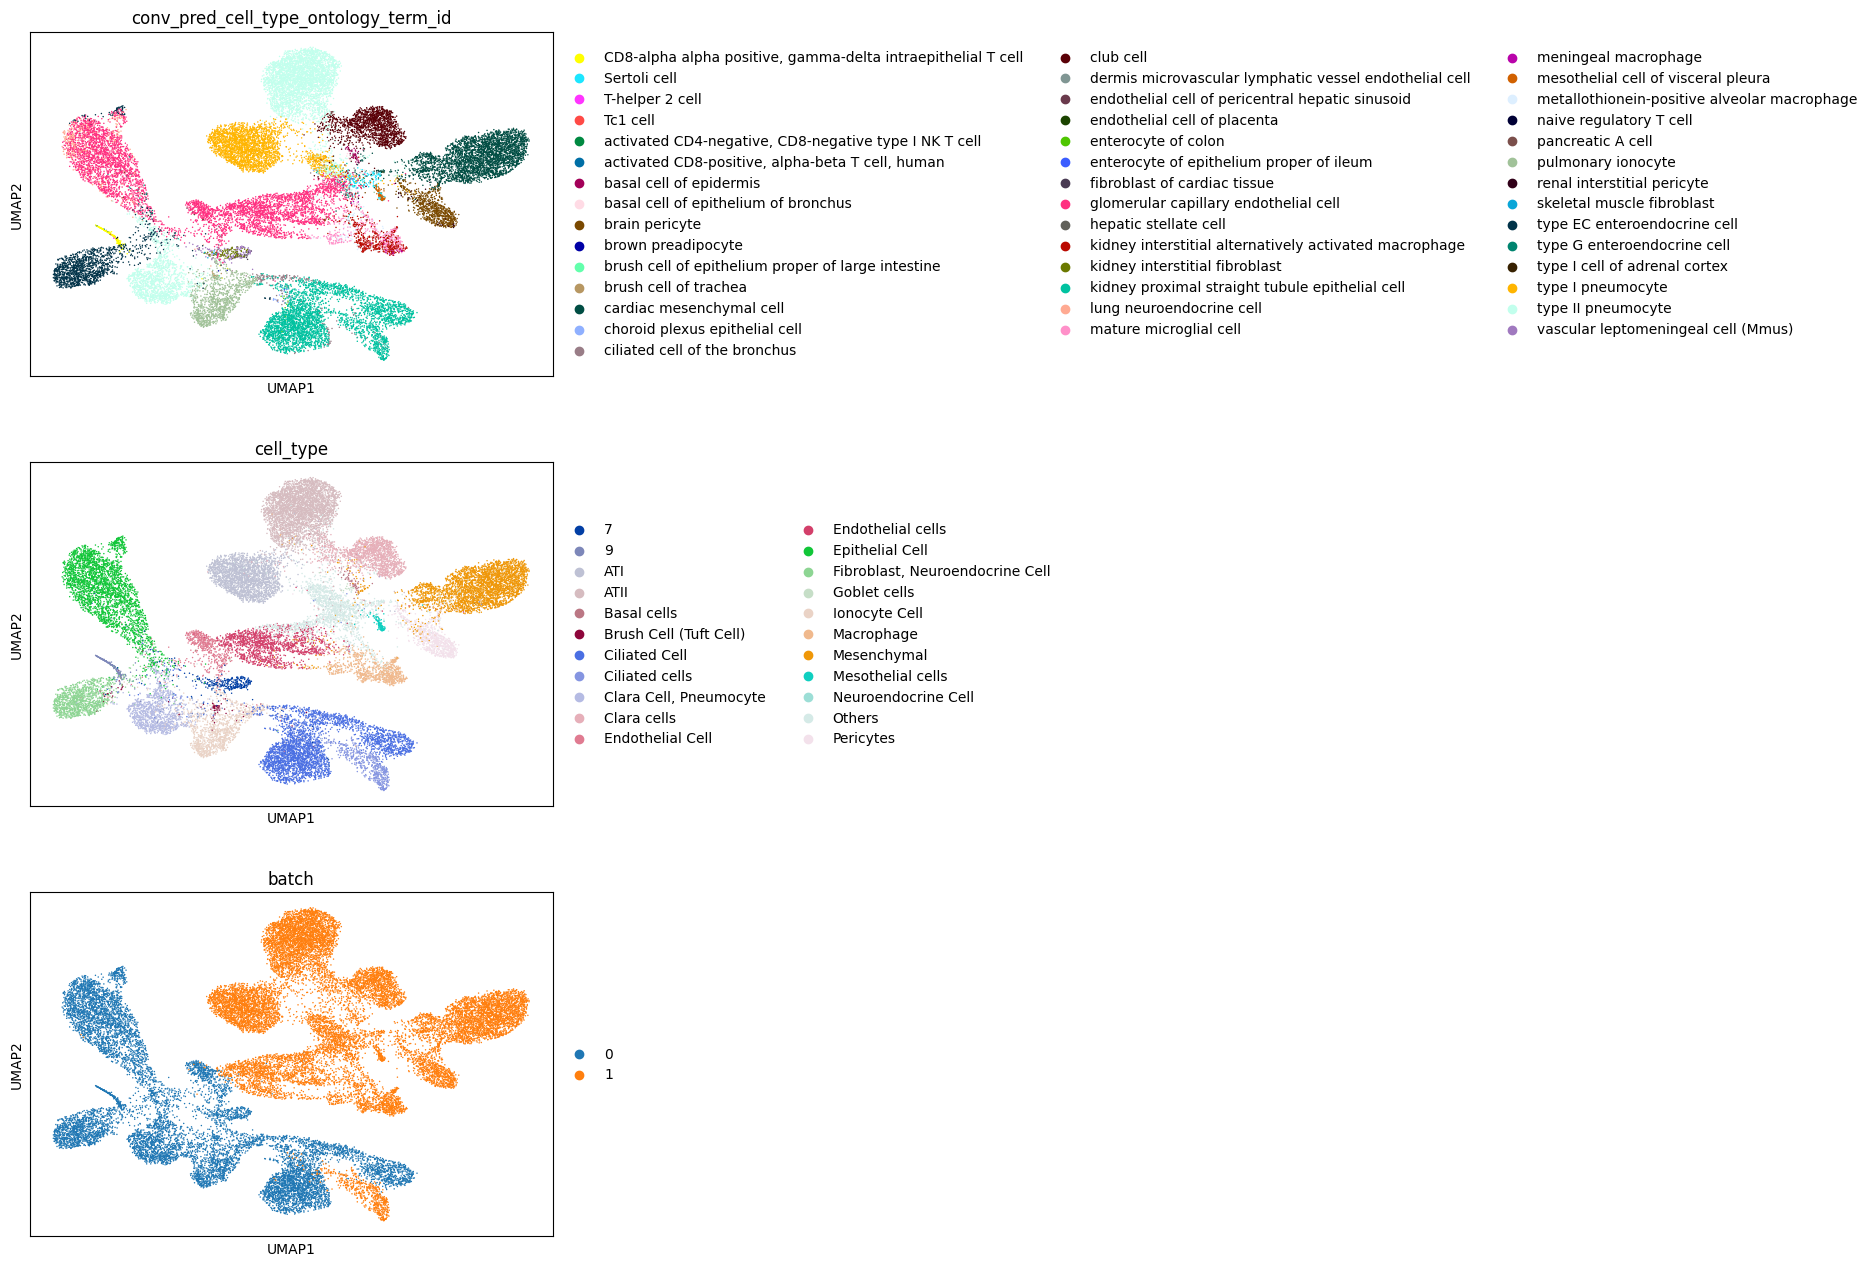

In [ ]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb_cell_type_ontology_term_id")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

... storing 'cell_type_ontology_term_id' as categorical


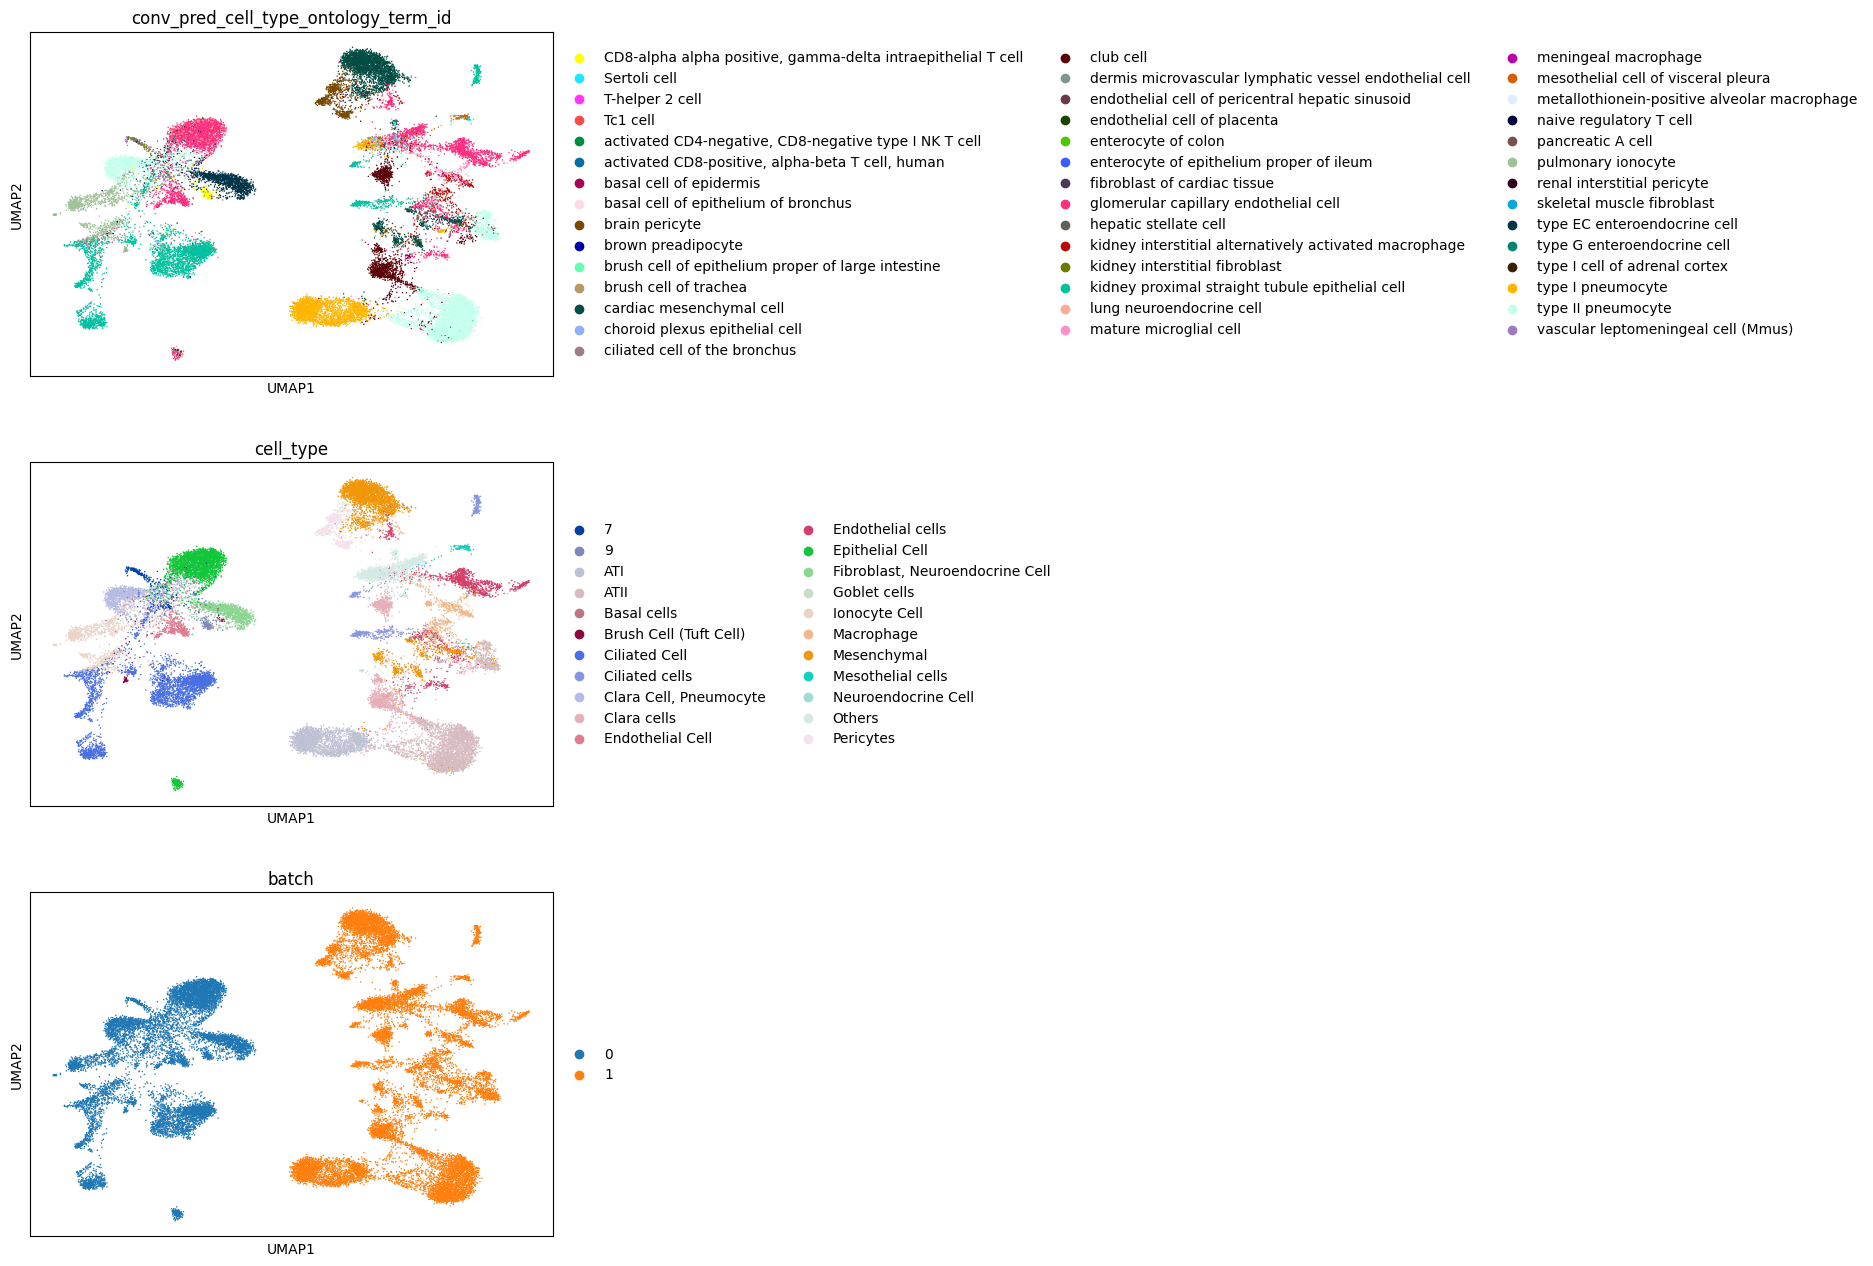

In [44]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

In [8]:
bm = Benchmarker(
    n_adata,
    batch_key="batch",  # batch, tech, assay_ontology_term_id, donor_id
    label_key="cell_type_ontology_term_id",  # celltype
    embedding_obsm_keys=["scprint_emb_cell_type_ontology_term_id"],
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    n_jobs=10,
)
bm.benchmark()

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(
Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]Sun Nov  2 15:36:57 2025 INFO isolated labels: no more than 1 batches per label
INFO:2025-11-02 15:36:57,659:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Sun Nov  2 15:36:57 2025 INFO Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Sun Nov  2 15:36:57 2025 WARNING An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not 

INFO     CL:0000057 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000066 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000077 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000084 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000158 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000160 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000165 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000235 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000322 consists of a single batch or is too small. Skip.   

Metrics:  70%|███████   | 7/10 [00:45<00:13,  4.59s/it, Batch correction: kbet_per_label]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 1/1 [00:46<00:00, 46.05s/it]


In [10]:
bm.get_results(min_max_scale=False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,BRAS,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
scprint_emb_cell_type_ontology_term_id,0.638532,0.813468,0.749773,0.691416,1.0,0.68521,0.0,0.012391,0.906902,0,0.320901,0.778638,0.595543
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


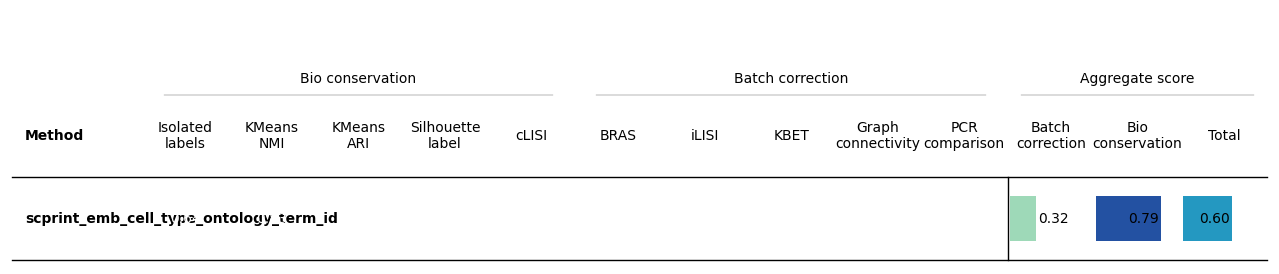

In [43]:
# after fine tuning
bm.plot_results_table(min_max_scale=False)

## on all


In [11]:
bm = Benchmarker(
    n_adata,
    batch_key="batch",  # batch, tech, assay_ontology_term_id, donor_id
    label_key="cell_type_ontology_term_id",  # celltype
    embedding_obsm_keys=["scprint_emb"],
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    n_jobs=10,
)
bm.benchmark()

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(
Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]Sun Nov  2 15:41:10 2025 INFO isolated labels: no more than 1 batches per label


INFO     CL:0000057 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000066 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000077 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000084 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000158 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000160 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000165 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000235 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000322 consists of a single batch or is too small. Skip.   

Metrics:  70%|███████   | 7/10 [05:21<01:01, 20.34s/it, Batch correction: kbet_per_label]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 1/1 [05:23<00:00, 323.09s/it]


In [12]:
bm.get_results(min_max_scale=False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,BRAS,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
scprint_emb,0.554376,0.721391,0.632545,0.55667,0.99973,0.582484,0.0,0.0,0.650126,0,0.246522,0.692943,0.514374
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


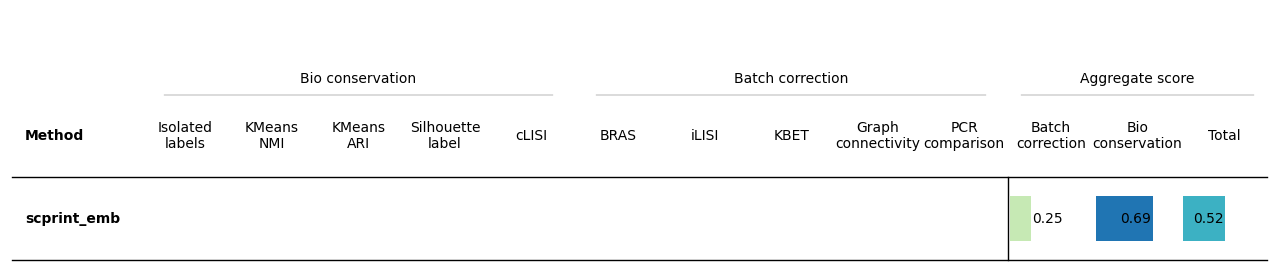

In [8]:
# after fine tuning
bm.plot_results_table(min_max_scale=False)